### Настройка и запуск spark <a class="anchor" id="first"></a>

[Настраивал как написано тут](https://blog.sicara.com/get-started-pyspark-jupyter-guide-tutorial-ae2fe84f594f)

In [ ]:
# !pip3 install findspark

In [2]:
import findspark
findspark.init('/home/elch10/spark-2.4.0-bin-hadoop2.7', 'python3')

In [3]:
from pyspark.sql import SparkSession
from pyspark import SparkConf

conf = (SparkConf().setMaster('local[2]')
        .set('spark.executor.memory', '2G')
        .set('spark.driver.memory', '2G')
        .set('spark.memory.fraction', '0'))
#         .set('spark.sql.execution.arrow.enabled', 'true')) # I can't make it work
spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [4]:
sc = spark.sparkContext

### Загрузим только содержание всех постов из json <a class="anchor" id="second"></a>

In [1]:
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import json
files = sc.wholeTextFiles("posts")

def extractContent(content):
    posts_content = []
    for post in json.loads(content):
        posts_content.append(post['text'])
    return posts_content

content = files.flatMapValues(extractContent).collect()

with open("ads_content.pkl", "wb") as ads_content:
    pickle.dump(content, ads_content)

Сохранял просто лист, но потом понял что удобнее будет работать с pandas.DataFrame, поэтому загружаю так:

In [16]:
with open("ads_content.pkl", "rb") as ads_content:
    content = pd.DataFrame(data=pickle.load(ads_content), columns=["filename", "content"])

In [29]:
content.head()

,filename,content
0,file:/home/elch10/Desktop/vk/posts/1311.json,🔥ГОРЯЧЕЕ ПРЕДЛОЖЕНИЕ🔥\n.\nПри брони свадебной ...
1,file:/home/elch10/Desktop/vk/posts/1311.json,"Соседи, помогайте! \nПропала кошка, Севастопол..."
2,file:/home/elch10/Desktop/vk/posts/1311.json,Меня зовут Павел Кочкин.\nЯ основатель проекта...
3,file:/home/elch10/Desktop/vk/posts/1311.json,"[club148413175|ФЕСТИВАЛЬ КРАСОК ""ART-FEST"" В Б..."
4,file:/home/elch10/Desktop/vk/posts/1311.json,Продажа оригинальной и удобной спортивной одеж...


Не знаю почему, но постов полученных по API оказалось чуть меньше 250 000

In [17]:
content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237755 entries, 0 to 237754
Data columns (total 2 columns):
filename    237755 non-null object
content     237755 non-null object
dtypes: object(2)
memory usage: 3.6+ MB


### Удалим всё кроме слов, сделаем лемматизацию, после этого применим TF-IDF <a class="anchor" id="third"></a>

In [ ]:
from pyspark.ml.feature import HashingTF, IDF, RegexTokenizer, Normalizer
from pyspark.ml import Pipeline

df = spark.createDataFrame(data=content.reset_index())

#### Извлекаем только слова

In [ ]:
tokenizer = RegexTokenizer(pattern="[^\\p{L}]", inputCol="content", outputCol="words")
ads_only_words = tokenizer.transform(df).select(["index", "words"])

ads_only_words.write.save("ads_only_words")

#### Лемматизация

**Код в следующей ячейке на моей машине выполнется около полутора часов...**

Проблема в том, что pandas_udf у меня совсем не хочет работать...

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from pymystem3 import Mystem

ads_only_words = spark.read.load("ads_only_words")

mystem = Mystem()

@udf(ArrayType(StringType()))
def lemmatize(array):
    # mystem for words return array - [word, whitespace], but we only need the lemmatized words
    # thus we only take the 0-th element
    return [mystem.lemmatize(word)[0] for word in array]

lemmatized = ads_only_words.withColumn("lemmatized", lemmatize("words")).drop("words")
lemmatized.write.save("lemmatized_words_with_id")

#### Удаление стоп слов

In [ ]:
from pyspark.ml.feature import StopWordsRemover

lemmatized = spark.read.load("lemmatized_words_with_id")

stop_words = StopWordsRemover.loadDefaultStopWords("russian")
stop_words_remover = StopWordsRemover(inputCol="lemmatized", outputCol="filtered", stopWords=stop_words)

stop_words_removed = stop_words_remover.transform(lemmatized)
stop_words_removed.select(["filtered", "index"]).write.save("words_filtered_with_id")

#### TF-IDF с нормализацией

После нормализации euclidean distance и cosine distance будут пропорциональны: https://stats.stackexchange.com/a/299016

In [ ]:
HASH_TABLE_SIZE = 2 ** 14

In [ ]:
stop_words_removed = spark.read.load("words_filtered_with_id")

#TF-IDF
hashingTF = HashingTF(numFeatures=HASH_TABLE_SIZE, inputCol="filtered", outputCol="frequencies")
idf = IDF(inputCol="frequencies", outputCol="tf_idf")

normalizer = Normalizer(inputCol="tf_idf", outputCol="normalized_tf_idf")

pipeline = Pipeline(stages=[hashingTF, idf, normalizer])

transformer = pipeline.fit(stop_words_removed)
preparedDF = transformer.transform(stop_words_removed)

preparedDF.select(["index", "normalized_tf_idf"]).write.save("prepared_%d" % HASH_TABLE_SIZE)

### KMeans <a class="anchor" id="fourth"></a>

Но тут он смог работать только на 1000 кластерах. На 2000 падает с нехваткой памяти. Также делал на 500 кластерах, но забыл про индексы, и в общем запускал всё зря...

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

preparedDF = spark.read.load("prepared_%d" % HASH_TABLE_SIZE)

In [7]:
with open("silhouettes_score.pkl", "rb") as fin:
    silhouettes = pickle.load(fin)

In [ ]:
%%time
for i in [1000, 2000]:#np.logspace(2.7, 4, num=4):
    kmeans = KMeans(featuresCol="normalized_tf_idf").setK(int(i)).setSeed(17)
    model = kmeans.fit(preparedDF)
    model.save('kmeans_%d.model' % int(i))
    
    # Make predictions
    prediction = model.transform(preparedDF)
    prediction.write.save('kmeans_%d.prediction' % int(i))

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator(featuresCol="normalized_tf_idf")
    silhouettes[int(i)] = evaluator.evaluate(prediction)

Можно заметить как я запускал на разных количествах кластеров, но опять же, я не знал про то, что spark может перемешивать строки как он хочет, чтобы решить эту проблему я ввёл индексы (но при предыдущих запусках их не было, поэтому я получал просто silhouette distance для них, но восстановить к какому именно документу принадлежит тот или иной вектор я бы не смог)

Но кластеризация всё равно не очень хороша была при малом количестве кластеров (если оценивать по silhouettes):

In [8]:
silhouettes

{100: -0.03638636036931625,
 166: -0.01900068298881791,
 278: -0.00819782981032901,
 464: 0.013298072323437247,
 501: 0.014315990633307865,
 1359: 0.07295370538858141,
 1000: 0.04889224038527698}

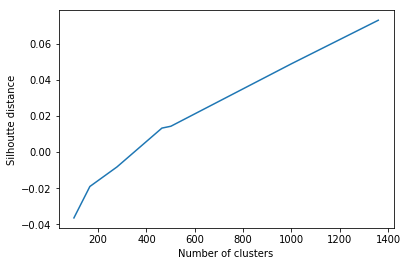

In [9]:
from operator import itemgetter
silhouettes = np.array(sorted(silhouettes.items(), key=itemgetter(0)))

plt.plot(silhouettes[:, 0], silhouettes[:, 1])
plt.xlabel('Number of clusters')
plt.ylabel('Silhoutte distance');

Впринципе кривая довольно крутая, возможно, с большим количеством кластеров, мы бы получили ещё более лучшую кластеризацию (по мнению silhouette)

In [ ]:
with open("silhouettes_score.pkl", "wb") as fout:
    pickle.dump(silhouettes, fout)

### Посмотрим на результаты KMeans с 1000 кластерами <a class="anchor" id="fifth"></a>

In [10]:
kmean_prediction = spark.read.load("kmeans_1000.prediction")
df = kmean_prediction.toPandas()
df.drop('normalized_tf_idf', axis=1, inplace=True)

grouped_by_prediction = df.groupby(by='prediction')
sizes = grouped_by_prediction.size()

In [11]:
def get_posts_from_cluster(cluster_number):
    idxs = grouped_by_prediction.get_group(cluster_number)['index']
    return content.loc[idxs, 'content'].values

#### Посмотрим на 65 кластер

In [12]:
sizes[65]

10

In [13]:
get_posts_from_cluster(65)

array(["Что самое важное в детской одежде? На этот вопрос каждая мама отвечает по-своему. Например, так.\n\n ▷ Сразу понравился яркий дизайн с забавной аппликацией и очень мягкая приятная к телу ткань. Порадовало, что в процессе носки и очень частых стирок вещи не садятся, не линяют и на них не образуются катышки. С этого и началась любовь к вещичкам данной фирмы! ◁ \n \nВысочайшее качество вещей, безопасные материалы, стильный дизайн, каждая вещь продумана до мелочей. Нет ничего приятнее сердцу мамы, чем когда ее малыш доволен. \n\n✈ Только топовые американские бренды: Carter's, Gymboree, Ralph Lauren, Children's Place.\n🙏 Работаем более 7 лет.\n🎯 Отправка в день заказа.\n👔 1300 позиций брендовой одежды в наличии на складе в Москве \n🛒 Помощь с выбором размеров и моделей.\n💌 По Москве и СПБ можем привезти несколько моделей разных размеров на выбор\n\n▷ Посмотреть все комплекты по акции: https://vk.com/market-20673835?section=album_54\n▷ По любым вопросам пишите в личные сообщения: vk.

Здесь алгоритм показывает себя не очень плохо

#### Посмотрим на 524 кластер (Пытался выбирать те, где не очень много постов)

In [14]:
sizes[524]

9

In [15]:
get_posts_from_cluster(524)

array(['Комментатор спит, матч идет. Дудь уснул, так это скучно. Разбуди себя, если хочешь больше крутых голов. Пора использовать 50% скидку на стрижку в барбершопе Chop-Chop от Head & Shoulders. \n#БольшеКрутыхГолов #ПокажиСебя \nЖми => https://vk.cc/89Nh1U',
       'Комментатор спит, матч идет. Дудь уснул, так это скучно. Разбуди себя, если хочешь больше крутых голов. Пора использовать 50% скидку на стрижку в барбершопе Chop-Chop от Head & Shoulders. \n#БольшеКрутыхГолов #ПокажиСебя \nЖми => https://vk.cc/89MRPA',
       'Комментатор спит, матч идет. Дудь уснул, так это скучно. Разбуди себя, если хочешь больше крутых голов. Пора использовать 50% скидку на стрижку в барбершопе Chop-Chop от Head & Shoulders. \n#БольшеКрутыхГолов #ПокажиСебя \nЖми => https://vk.cc/89Nh1U',
       'Комментатор спит, матч идет. Дудь уснул, так это скучно. Разбуди себя, если хочешь больше крутых голов. Пора использовать 50% скидку на стрижку в барбершопе Chop-Chop от Head & Shoulders. \n#БольшеКрутыхГолов 

Просто один и тот же текст был в нескольких разных постах

#### Посмотрим немного остальные кластеры

Самый большой кластер

In [16]:
sizes[sizes.idxmax()]

62450

Посмтрим первые 5 постов и последние 5 постов из этой группы

In [17]:
posts = get_posts_from_cluster(sizes.idxmax())

In [18]:
posts[:5]

array(['Только для жителей Автовокзала, которые любят путешествовать!\n \n🎁Успей получить путешествие за лайк! ЖМИ⬇',
       'Декоратор/дизайнер событий? Рост и развитие нельзя откладывать в долгий ящик. \n🔥Идет набор на марафон "Путь декоратора", где учат работать по другому.\nСпеши записаться по супер цене. 📢 15 июня цена поднимется вдвое!',
       'До Games Job Fair St. Petersburg осталось всего две недели, самое время рассказать вам о месте проведения нашей ярмарки! \n30 июня мы соберемся в [club8938143|ТЕХНОПАРКЕ САНКТ-ПЕТЕРБУРГА]. Здесь высокотехнологичные проекты получают поддержку, необходимую для дальнейшего роста. Бизнес-инкубатор был создан в 2008 году и за это время они помогли более чем 200 стартапам сделать первые шаги на рынке, сформировать профессиональную команду, получить инвестиции и найти клиентов. Узнать больше о деятельности Ингрии можно на сайте: http://ingria-park.ru. \nИ не забывайте, что регистрация на мероприятие все еще открыта: fgday.com.',
       'Если для

In [19]:
posts[-5:]

array(['Частные обзорные экскурсии и экскурсии с гидом по Минску и другим местам!\nhttps://www.chauffeur.by/excursions-within-belarus',
       'Привет фанатам Баффета! Меня зовут Вячеслав Базылов. Уже более 15 лет я занимаюсь инвестициям, управлял фондами до 40 миллионов долларов. В 2009 году достиг звания лучшего портфельного управляющего Украины по версии UAIB, Ukrainian Exchange. \n \nВ 2011 году победил в конкурсе «Лучший Частный Инвестор» в номинации: «Самый прибыльный трейдер» (Dragon Capital, Ukrainian Exchange). Затем начал заниматься криптовалютами. \n \nСо временем, мне захотелось поделиться своими навыками и опытом со всеми, и я начал вести свои личные обучающие семинары и курсы. Приглашаю посетить и вас, на один из них, в ходе которого вы поймете ситуацию на рынке целиком. \n \nУзнайте более подробную программу и зарегистрируйтесь на сайте: https://clck.ru/Dc2Av',
       '🏡 Подбираете новостройку в центре Москвы?\nСкачайте бесплатный каталог элитных новостроек центра Москвы

Можно сделать только один вывод - количество кластеров было не достаточным, чтобы предсказывать правильно

Можно посмотреть ещё на 722 группу, она тоже довольно большая

In [20]:
sizes[722]

287

In [21]:
posts = get_posts_from_cluster(722)

In [22]:
posts[:5]

array(['Установили очень глубокий шкаф купе!!!!😏😏😏\n-корпус ЛДСП белый кантри\n-наполнение фасадов зеркало\n-профиль версаль серебро',
       '📣 Специальная цена для наших подписчиков на этой неделе! \n✨ Шкаф-купе "Альянс-3" 2000 - всего 12990₽👍 \n✅ Только с 18 по 24 июня! \n➡ Посмотреть на сайте: https://clck.ru/DcWft',
       'Дизайнер интерьера из Екатеринбурга? Проектируй мебельные детали онлайн! \nВ ROOMATIC ты можешь заказать и оплатить: 📌распил ЛДСП, 📌фасады и панели МДФ, 📌двери для шкафов-купе и многое другое! \nПопробуй!',
       '🔥 Горячие дни модного шопинга 🔥 \nНаполняй свой шкаф красотой — получай кэшбэк 15% + выигрывай классные призы! Регистрируйся и не пропусти акцию💡',
       'Как приготовить спагетти с соусом из фарша и кабачковой икры? Смотрите пошаговый рецепт.'],
      dtype=object)

In [23]:
posts[-5:]

array(['"Нужен шкаф-купе для троих сыновей!" 👦 — обратилась к нам Надежда. \n\nУ каждого должна быть своя секция. А ещё шкаф должен быть особенно прочным, потому что его будущие обладатели — настоящие разбойники😏\n\nПоэтому мы сделали двери шкафа из целикового лдсп. Кто знает, вдруг случится захват корабля? Ой, то есть шкафа-купе... Ну да не важно🙂 Наш герой готов к любым приключениям!\n\nНадежда осталась довольна, а шкаф приступил к выполнению службы!👍 \n\nP.S. А у ваших непосед уже есть шкаф-купе?\n\nВаши лайки ❤ будут нам очень приятны!',
       'Небольшая гардеробная для прихожей в коттедж в г. Брянске. \n \nОбратившись к нам в студию мебели «Проект» Наталья высказала свои пожелания по поводу оформления дверей-купе. После замера и осмотра помещения мы предложили ей скомбинировать черное крашеное стекло Locabel и зеркало – ведь как видно на фото именно такое сочетание элементов очень стильно и органично вписалось в интерьер прихожей. \n \n⚠ Но, главное, при таком оформлении шкафа, п

Можно сделать вывод - пока кластеризация не идеальная. Одной из причин может быть то, что много внимания уделается слову "шкаф"

### LDA <a class="anchor" id="sixth"></a>

In [4]:
stop_words_removed = spark.read.load("words_filtered_with_id")
stop_words_removed.printSchema()

root
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- index: long (nullable = true)



Выбрал такие minDF, maxDF, делая вывод [отсюда(1 пункт ответа)](https://www.quora.com/What-are-good-ways-of-evaluating-the-topics-generated-by-running-LDA-on-a-corpus)

Немного подредактировал, но не могу претендовать на то, что они идеальные.

У нас есть не очень большие посты, поэтому сделать minDF=3 мне показалось разумным, с maxDF понятно - в текстах могут присутствовать некоторые часто встречающиеся слова, которые будут только мешать кластеризации. Они будут как "стоп слова".

In [5]:
from pyspark.ml.feature import CountVectorizer

VOCABULARY_SIZE = 2 ** 14

count_vectorizer = CountVectorizer(vocabSize=VOCABULARY_SIZE, minDF=3, maxDF=0.6, 
                                  inputCol="filtered", outputCol="frequencies")
model = count_vectorizer.fit(stop_words_removed)
model.save('count_vectorizer.model')

preparedDF = model.transform(stop_words_removed)
preparedDF.select(['index', 'frequencies']).write.save('count_vectorized')

In [7]:
preparedDF = spark.read.load('count_vectorized')
cluster_sizes = [100, 250, 500]

In [8]:
from pyspark.ml.clustering import LDA
for k in cluster_sizes:
    lda = LDA(featuresCol='frequencies', k=k)
    transformer = lda.fit(preparedDF)
    transformer.save('lda_%d.model' % k)
    
    transformed = transformer.transform(preparedDF)
    transformed.write.save('lda_%d.prediction' % k)

Perplexity не получилось посчитать, оно было слишком долгим (работало ночь и не закончило) и я решил убить эти процессы

In [ ]:
# with open('logPerplexity.pkl', 'rb') as fout:
#     perplexities = pickle.load(fout)

# perplexities = {}
# for k in cluster_sizes:
#     transformer = LocalLDAModel.read().load('lda_%d.model' % k)
#     perplexities[k] = transformer.logPerplexity(preparedDF)

# with open('logPerplexity.pkl', 'wb') as fout:
#     pickle.dump(perplexities, fout)

### Посмотрим результаты LDA c 500 тегами <a class="anchor" id="seventh"></a>

Посмотрим на какие 10 наиболее значительных слов обращали внимания первые 5 топиков

In [ ]:
from pyspark.ml.clustering import LocalLDAModel
lda500 = LocalLDAModel.read().load('lda_500.model')
topics = lda500.describeTopics(10)

In [14]:
pandas_df = topics.limit(5).toPandas()
pandas_df.head()

,topic,termIndices,termWeights
0,0,"[1782, 9654, 3546, 6804, 7681, 2821, 7614, 865...","[8.656864731874494e-05, 8.56053000175406e-05, ..."
1,1,"[1664, 13884, 812, 7675, 6769, 2069, 15881, 88...","[9.017187807147295e-05, 8.6422938360876e-05, 8..."
2,2,"[14644, 10085, 2653, 11254, 1518, 7680, 12634,...","[8.654726877878155e-05, 8.593843244862693e-05,..."
3,3,"[5080, 5434, 4428, 8984, 14785, 3911, 1452, 11...","[8.640544333145997e-05, 8.635177402531849e-05,..."
4,4,"[232, 521, 0, 3471, 247, 2893, 4154, 1037, 183...","[0.023269244671920257, 0.009289528050790526, 0..."


In [9]:
from pyspark.ml.feature import CountVectorizerModel
count_vectorizer = CountVectorizerModel.load('count_vectorizer.model')

In [18]:
pd.set_option('display.max_colwidth', -1)
pandas_df['termIndices'].apply(lambda el: [count_vectorizer.vocabulary[index] for index in el])

0    [радоваться, самодиагностика, отключать, печально, нитка, забор, фатых, доезжать, поделиться, аркаим]
1    [спасать, reserve, закрытый, дергать, поединок, шт, холодок, мировоззрение, смелый, фотка]           
2    [стамбул, полярный, ненужный, ажиотаж, срочно, ильнур, dodo, пищевой, тревожиться, маркировка]       
3    [дисплей, сосновый, прыгать, boom, щука, явно, помещение, uchus, переедание, обеспечение]            
4    [энергия, повышать, это, гормон, здоровье, самочувствие, энергичность, лень, уровень, усталость]     
Name: termIndices, dtype: object

Если присмотреться, то можно заметить, что только в 4-ом топике получилось что-то вразумительное, что-то связанное со здоровьем

In [5]:
predictions = spark.read.load('lda_500.prediction')
predictions.printSchema()

root
 |-- index: long (nullable = true)
 |-- frequencies: vector (nullable = true)
 |-- topicDistribution: vector (nullable = true)



In [7]:
distribution_df = predictions.select(['index', 'topicDistribution']).toPandas()

In [35]:
distribution_df.set_index(distribution_df['index'], inplace=True)
distribution_df.drop(columns='index', inplace=True)
distribution_df.head()

,topicDistribution
index,
118784,"[0.0003982792925933001, 0.0003982792925933001,..."
118785,"[2.457695358310222e-05, 2.457695358310222e-05,..."
118786,"[0.00014221014342903797, 0.0001422101434290379..."
118787,"[0.00018100098649866337, 0.0001810009864986633..."
118788,"[4.0627790330978677e-05, 4.0627790330978677e-0..."


Будем искать похожие документы по [Jensen-Shannon Distance](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence)

[Источник:](https://gist.github.com/zhiyzuo/f80e2b1cfb493a5711330d271a228a3d)

In [36]:
import scipy.stats

def jsd(p, q, base=np.e):
    '''
        Implementation of pairwise `jsd` based on  
        https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence
    '''
    ## convert to np.array
    p, q = np.asarray(p), np.asarray(q)
    ## normalize p, q to probabilities
    p, q = p/p.sum(), q/q.sum()
    m = 1./2*(p + q)
    return scipy.stats.entropy(p,m, base=base)/2. + scipy.stats.entropy(q, m, base=base)/2.

from operator import itemgetter
import numpy as np

def get_similar_documents(document_idx, top_n=5):
    current_document = distribution_df.loc[document_idx]
    similarities = []
    
    for idx, row in distribution_df.drop(index=document_idx).iterrows():
        similarities.append([idx, jsd(current_document['topicDistribution'], row['topicDistribution'])])
    similarities.sort(key=itemgetter(1))
    
    similar_documents = []
    for idx, _ in similarities[:top_n]:
        similar_documents.append(content.loc[idx, 'content'])
    return similar_documents

#### Найдем похожие для документа с индексом 4

In [39]:
content.loc[4, 'content']

'Продажа оригинальной и удобной спортивной одежды от российских производителей по соотношению цена качество.👍👍👍'

In [40]:
get_similar_documents(4)

/home/elch10/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


['Более 6000 единиц стильной женской одежды с ценами от производителя и бесплатной доставкой по всей Украине!',
 'Работай в ресторане рядом с домом. Зарплата 31 000 руб. + до 13 500 руб. премия! Заполни анкету онлайн',
 'Работай в ресторане рядом с домом. Зарплата 31 000 руб. + до 13 500 руб. премия! Заполни анкету онлайн',
 'Работай в ресторане рядом с домом. Зарплата 31 000 руб. + до 13 500 руб. премия! Заполни анкету онлайн',
 'Подарите своей кухне стеклянный фартук от ведущего производителя на Урале. Всего от 4200 руб. м.кв.']

#### Ну и похожие на последний элемент

In [47]:
content.loc[237754, 'content']

'НОВОКУЗНЕЦК! ☄УЖЕ 6 июля состоится грандиозное выступление Дивы российского шоу-бизнеса - неподражаемой [club868146|Ани Лорак] \n\n☄Концерт в честь дня города #Новокузнецк400\nВстречаемся на площади общественных мероприятий Центрального района! \nНЕ ПРОПУСТИ!'

In [48]:
get_similar_documents(237754)

/home/elch10/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


['Июнь 1968 года. Радикальная феминистка Валери Соланас покупает пистолет и едет в офис к королю поп-арта Энди Уорхолу. \n\nОзвучка Иван Дорн',
 '🎥Киноклуб TODAY приглашает всех киноманов в АртКинотеатр "RELAX CLUB" на просмотр фильма "Игры разума" 30 октября в 19:40! \nСтоимость пригласительного - 100 р.',
 "Kaiser's Religion invites you to KaiserDom*\n \nМы открываем сезон вечеринок KaiserDom, и для первой нашей встречи была выбрана абсолютно новая локация, где Вы точно еще не были. Лайнап порадует Вас громкими именами и громкой хаус-музыкой.\n\nВсех гостей вечеринки ждёт сюрприз, а то давно мы ничего не показывали.\n\n18+ \nFC / DC\nFREE ENTER\n \n22:30\n04/07/2018 \nlocation: Chains Bar (Болотная наб. 3/2) \n \nрегистрация на мероприятие: \n- репост этой записи \n- ФИО в комментарии \n\nline-up:\n\n☭ Cream Soda\n☭ Maxéncio Denisovi\n☭ Mukha\n☭ Mucity\n☭ John505 + Teache\n☭ Identichniy\n\n* KaiserDom - собор Кайзера\n** приходите к началу, будет welcome drink 🖤\n*** репост в день ме

Качество LDA мне показалось немного хуже, чем у KMeans, хотя чтобы делать такие выводы нужен более детально проверить каждый из этих методов

### Возможные улучшения <a class="anchor" id="eighth"></a>

Можно было бы попробовать ещё:
- ngram
- gaussian mixture model
- нейронные сети (например, BERT, pytext и т.д.)
- попробовать свести задачу к supervised подходу (тематики взять из групп)

Попробованные решения в принципе можно будет использовать в продакшене. Они выполняются не очень долго. Можно ещё ускорить, если уменьшить выборку и сделав tunning количества кластеров в kmeans или topics в LDA. Но оценивать качество unsupervised подходов довольно сложно, возможно, пришлось бы самому просматривать кластеры и оценивать качество "глазами".

С другой стороны, если свести всё-таки к supervised подходу, то наверное, для оценки можно использовать метрики описанные [здесь](https://stats.stackexchange.com/a/234354) (по сути в группе может быть описано несколько тематик, по этому это multilabel classification). Так же, например, hamming score довольно не плохо интерпретируем.